<H1> Audio Classification and Denoising </H1>

<H2> <i> By Thushar Ishwanthlal </i> </H2>

In this script, we are going to take a look at preprocessing and applying Deep Learning techniques to Audio Data.

Two problems are tackled in this document: 

 <b>-> Classification : </b> The ability to classify speech into text helps is with many everyday items. It is a tool that several apps use as an accessibility feature, and being able for the machine to understand human speech also gives it access to more data to train different models on. Here we take a look at a very basic classificaiton set, on the road to understanding human speech.

 <b>-> Denoising : </b> Many Sound Datasets come with imperfect sound, whether it is the mic quality of a lecturer or a dog barking in the background. Being able to tease out undesirable information will allow the machine to better interpret human speech, ameliorating it's usefulness and improving sound models.


 Data : https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz

In [20]:
import os
import urllib.request
import tarfile
import glob

from collections import Counter

import matplotlib.pyplot as plt
import IPython.display as ipd
import tensorflow as tf

import numpy as np
import random
import librosa

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras import Sequential, layers, Model
import tensorflow.keras.backend as K
import keras

import gc

DATA_DIR = "data"

# url = "https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz"
# filename = "speech_commands_v0.02.tar.gz"

# if not os.path.exists(filename):
#     print("Downloading...")
#     urllib.request.urlretrieve(url, filename)

# print("Extracting...")
# with tarfile.open(filename, "r:gz") as tar:
#     tar.extractall(path=DATA_DIR)

# print("Done!")

gpus = tf.config.list_physical_devices('GPU')
print(tf.test.is_built_with_cuda())
print(gpus)

False
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<H2> EDA </H2>

The data consists of 35 different "command" type words. being spoken by various individuals. It additionally has background clips of about a minute each.

In [3]:
data_list = os.listdir("data")

print(data_list)

num_commands = len([x for x in data_list if x not in ["_background_noise_", ".DS_Store"] ])
print(f"Number of Command Words: {num_commands}")

['.DS_Store', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero', '_background_noise_']
Number of Command Words: 35


In [21]:
os.listdir("data/_background_noise_")

['doing_the_dishes.wav',
 'dude_miaowing.wav',
 'exercise_bike.wav',
 'pink_noise.wav',
 'running_tap.wav',
 'white_noise.wav']

For this assignment, I select a subset of this data: 8 words which I could see as a command list in an audio-controlled video game. These eight words would make a good proof of concept, without confusing the model with words like "Sheila" or "Marvin", but being able to purely focus on the words that are on the command list.

In [4]:
TARGET_WORDS = [
    'yes', 'no',
    'up', 'down',
    'left', 'right',
    'go', 'stop'
]

index_dict = {TARGET_WORDS[i]: i for i in range(len(TARGET_WORDS))}
index_dict_inv = {v:k for k,v in index_dict.items()}

files = []
labels = []

for label in TARGET_WORDS:
    folder = os.path.join(DATA_DIR, label)
    audio_snippets = glob.glob(os.path.join(folder, "*.wav"))
    for audio_path in audio_snippets:
        files.append(audio_path)
        labels.append(index_dict[label])

print(f"Number of Audio Samples :  {len(files)}")
print("Label Mapping:", index_dict)



Number of Audio Samples :  30956
Label Mapping: {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'go': 6, 'stop': 7}


In [5]:
ipd.Audio(files[0])

In [5]:
ipd.Audio(files[-1])

Text(0.5, 1.0, 'Distribution of Labels in Train Set')

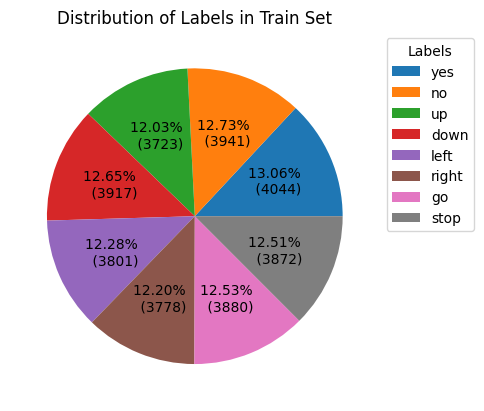

In [4]:
pie_data = Counter(labels)
pie_data_labs = [index_dict_inv[i] for i in pie_data.keys()]
pie_data_vals = pie_data.values()

#https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}% \n ({v})'.format(p=pct, v=val)
    return my_autopct

plt.pie(pie_data_vals, autopct=make_autopct(pie_data_vals))
plt.legend(
    pie_data_labs,
    title="Labels",
    loc="upper left",
    bbox_to_anchor=(1,1)
)
plt.title("Distribution of Labels in Train Set")

Longest Sample: 1.0


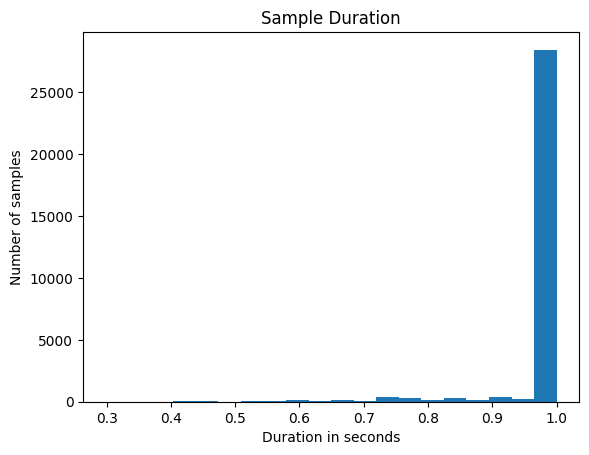

In [7]:
lengths = [librosa.get_duration(path=x) for x in files]

plt.hist(lengths, bins=20)
plt.title("Sample Duration")
plt.ylabel("Number of samples")
plt.xlabel("Duration in seconds")

print(f"Longest Sample: {max(lengths)}")

As we can see above, this is a very balanced dataset. This is natural, as they seemed to have surveyed various people to say the same words various times on the mic.

<H2> Plan </H2>

<b>Step 1 : Preprocessing -></b> We need to be able to convert the sound data into a machine learning ready form (and back). Padding the commands to 1 second.

<b>Step 2 : Classification -></b> Test our deep learning models to see which can give us the best result. We will take a look at all of NN, CNN, RNN, and combinations.

<b>Step 3 : Augmentation -></b> We will take a look at the process of creating new data. This data will be used in out denoising algorithm as the inputs, where the outputs will be the original samples.

<b>Step 4 : Denoising -></b> We will train an autoencoder on the samples we created in order to train the model to clarify the sound that we hear. 

<H2> Preprocessing <H2>

<H3> Converting Audio Data to be used in Machine Learning </H3>

In order to use Audio Data, we must convert it into tensors. However it is hard (impossible) to convert the pure waveform into tensors directly, In order to accompish this, we instead divide the audio file into small intervals (the smaller the better) and fourier transform the data at each interval. This gives a function showing us how much of a frequency is used during that period. This function is called the <b> short-term fourier transform. (STFT) </b>

We then apply a <b>mel filter</b>, which tranforms the data into human understandable bins, since direct frequency is not heard linearly by the human ear. We bin frequencies of the STFT into frequencies that sound similar to the human ear. This step is important if we want the model to respect what audio sounds similar to the human ear.

Basically, by binning once along the time axis (STFT), and once along the frequency axis (MEL Filter) we end up with a matrix that represents sound. The graph that this creates is called a <b> Mel Spectrogram</b>.

For more about getting started with audio data: https://www.youtube.com/watch?v=j6NTatoi928

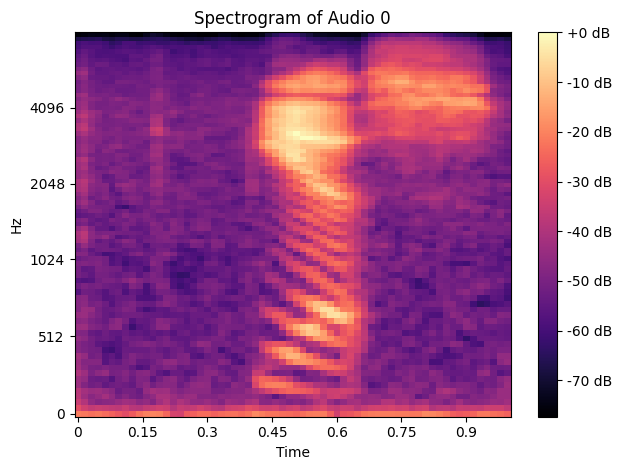

In [7]:
SAMPLE_RATE = 16000
MEL_BINS = 80
DURATION = 1.0

WINDOW = 1024
FRAME = 253

MEL_FILTER = librosa.filters.mel(sr=SAMPLE_RATE, n_fft=WINDOW, n_mels=MEL_BINS)

def load_audio_spectrogram(path_or_audio, filter=MEL_FILTER, from_file=True):
    if from_file:
        audio, _ = librosa.load(path_or_audio, sr=None, mono=True)
    else:
        audio = path_or_audio

    audio_len = int(SAMPLE_RATE * DURATION)

    if len(audio) < audio_len:
        audio = np.pad(audio, (0, audio_len - len(audio)))
    elif len(audio) > audio_len:
        audio = audio[:audio_len]

    stft = np.abs(librosa.stft(audio, n_fft=WINDOW, hop_length=FRAME))**2
    mel = filter @ stft

    return librosa.power_to_db(mel, ref=np.max)

def display_spec_quick_plot(plot, message=None):
    librosa.display.specshow(
        plot,
        sr=SAMPLE_RATE,
        hop_length=FRAME,
        x_axis="time",
        y_axis="mel"
    )

    if message is None:
        message=plot
    
    plt.title(f"Spectrogram of Audio {message}")
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

def display_spec_quick(id):
    display_spec_quick_plot(load_audio_spectrogram(files[id]), message=id)


display_spec_quick(0)
ipd.Audio(files[0])

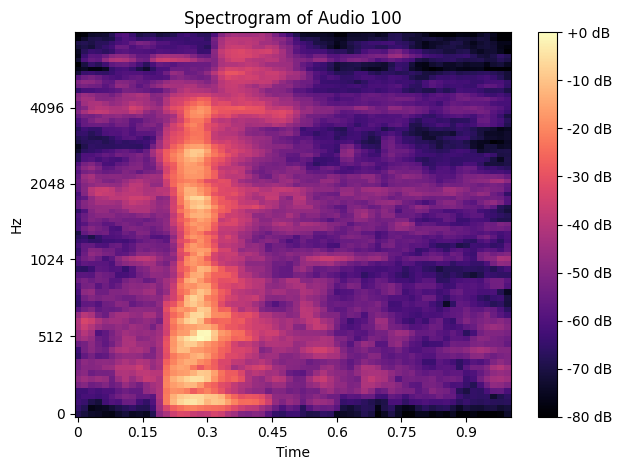

In [19]:
display_spec_quick(100)
ipd.Audio(files[100])

Since we are planning to to create a denoising algorithm, we also need to talk about the inverse. In this paper we use the Griffin-Lim Algorithm in order to estimate the missing information from just the mel spectrogram alone. note that this not only the frequency amounts in their unbinned form, but also phase information.

In [11]:
def mel_to_audio(mel_spect, normed=False):
    if normed:
        mel_spect = mel_spect * 80.0 - 80.0
    
    mel_power = librosa.db_to_power(mel_spect)

    linear_power = librosa.feature.inverse.mel_to_stft(
        mel_power,
        sr=SAMPLE_RATE,
        n_fft=WINDOW
    )

    audio = librosa.griffinlim(
        linear_power,
        n_iter=120,
        n_fft=WINDOW,
        hop_length=FRAME
    )
    
    audio = audio / ((np.max(np.abs(audio)) + 1e-9) )

    return audio

test_sp = load_audio_spectrogram(files[100])
test_sp_cyc = mel_to_audio(test_sp)


# Audio after cycling to and from mel spectrogram
ipd.Audio(test_sp_cyc, rate=SAMPLE_RATE)

In [ ]:
# Original Audio
ipd.Audio(files[100])

<H3> Caching the processed Data </H3>

The data is chached in Mel Spectrogram form for safekeeping and easy access.

In [16]:
X = []
y = []

for f, l in zip(files, labels):
    img = load_audio_spectrogram(f)
    X.append(img)
    y.append(l)

X = np.array(X)[..., np.newaxis]
y = np.array(y)

X = (X + 80.0) / 80.0

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (30956, 80, 64, 1)
y shape: (30956,)


In [17]:
np.save("X.npy", X)
np.save("y.npy", y)

In [7]:
X = np.load("X.npy")
y = np.load("y.npy")

print("X:", X.shape, "y:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)

X: (30956, 80, 64, 1) y: (30956,)
Train: (24764, 80, 64, 1) Test: (6192, 80, 64, 1)


<H3> Creating the Datatet </H3>

We use tensorflows Dataset object in order to hold and deliver the data for smooth dataflow. 

In [ ]:
BATCH_SIZE = 256

def make_dataset(X, y=None, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = make_dataset(X_train, y_train)
test_dataset = make_dataset(X_test, y_test)

<H2> Classification </H2>

In this section, we create deep neural network models to classify the sounds to their labels. The inputs are all the Mel Spectrograms, and the outputs are the labels 0-7, one for each of the categories. 

The functions below are designed to abstract the ability to create the models, making it easier to test work with and tune their parameters. 

In [10]:
# MODEL BUILDING FUNCTIONS

# Creates a Feed Forward, Dense Neural Network with the prescribed archetecture. 
def build_nn(input_shape, layer_neurons=[256, 128], dropout=0.3, num_classes=8) -> Sequential:
    model = Sequential()
    model.add(layers.Flatten(input_shape=input_shape))

    for i in layer_neurons:
        model.add(layers.Dense(i, activation="relu"))
        model.add(layers.Dropout(dropout))

    model.add(layers.Dense(num_classes, activation="softmax"))

    return model

# Creates a Convolutional Neural Network with the prescribed archetecture. conv_layers is the number of filters in each layer. 
def build_cnn(input_shape, conv_layers=[32,64,128], fc_layer=128, dropout=0.3, normalized=True, num_classes=8) -> Sequential:
    model = Sequential()

    model.add(layers.Input(shape=input_shape))

    for i in range(len(conv_layers)):
        model.add(layers.Conv2D(conv_layers[i], 3, padding="same", activation="relu"))
        model.add(layers.ReLU())

        if i < len(conv_layers) - 1:
            model.add(layers.MaxPooling2D(pool_size=2, strides=2))
        else:
            model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(fc_layer, activation="relu"))

    if normalized: model.add(layers.BatchNormalization())

    model.add(layers.Dense(num_classes, activation="softmax"))

    return model

# Creates a Recurrent Neural Network with the prescribed archetecture. conv_layers is the number of filters in each layer.
def build_rnn(input_shape, dropout=0.3, cell_type=["simple"], neurons=[128],  bidirectional=[False], normalized=True, num_classes=8):
    time_steps = input_shape[0]
    freq_activation = input_shape[1]

    model = Sequential()

    model.add(layers.Input(shape=input_shape))
    model.add(layers.Reshape((time_steps, freq_activation)))

    for i in range(len(cell_type)):
        ret_seq = (i < len(cell_type) - 1)

        if cell_type[i] == "lstm":
            rnn_layer = layers.LSTM(neurons[i], return_sequences=ret_seq)
        elif cell_type[i] == "gru":
            rnn_layer = layers.GRU(neurons[i], return_sequences=ret_seq)
        else:
            rnn_layer = layers.SimpleRNN(neurons[i], return_sequences=ret_seq)

        if bidirectional[i]:
            rnn_layer = layers.Bidirectional(rnn_layer)
        
        model.add(rnn_layer)
        model.add(layers.Dropout(dropout))

    if normalized: model.add(layers.BatchNormalization())
    model.add(layers.Dense(num_classes, activation="softmax"))
    return model

# Combines the Convolutional and Recurrent Neural Networks into one
def build_crnn(input_shape, conv_layers=[32, 64],rnn_cells=["simple"],rnn_units=[64],bidirectional=[True],
    dropout=0.3,fc_layer=128,normalized=True,num_classes=8
) -> Sequential:

    model = Sequential()
    model.add(layers.Input(shape=input_shape))

    for i in range(len(conv_layers)):
        model.add(layers.Conv2D(conv_layers[i], 3, padding="same", activation="relu"))
        model.add(layers.MaxPooling2D(pool_size=(1, 2)))

    time_steps = model.output_shape[1]
    freq_dim   = model.output_shape[2]
    channels   = model.output_shape[3]

    model.add(layers.Reshape((time_steps, freq_dim * channels)))

    for i in range(len(rnn_cells)):
        ret_seq = (i < len(rnn_cells) - 1)

        if rnn_cells[i] == "gru":
            rnn_layer = layers.GRU(rnn_units[i], return_sequences=ret_seq)
        elif rnn_cells[i] == "simple":
            rnn_layer = layers.SimpleRNN(rnn_units[i], return_sequences=ret_seq)
        else:
            rnn_layer = layers.LSTM(rnn_units[i], return_sequences=ret_seq)

        if bidirectional[i]:
            rnn_layer = layers.Bidirectional(rnn_layer)

        model.add(rnn_layer)
        model.add(layers.Dropout(dropout))

    model.add(layers.Dense(fc_layer, activation="relu"))

    if normalized: model.add(layers.BatchNormalization())

    model.add(layers.Dense(num_classes, activation="softmax"))

    return model


In [11]:
# Learning Hyperparameter Options
exp_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1.2e-3, decay_steps=100, decay_rate=0.98)

opt_dict = {
    "adam_exp" : tf.keras.optimizers.Adam(learning_rate=exp_decay),
    "adam" : tf.keras.optimizers.Adam(learning_rate=1e-3),
    "adam_hlr" : tf.keras.optimizers.Adam(learning_rate=2e-3)
}

loss_dict = {"SCCE": tf.keras.losses.SparseCategoricalCrossentropy()}

In [12]:
# MODEL TESTING FUNCTIONS

# gives predictions based on a dataset
def predict_from_dataset(model, dataset):
    y_probs, y_true = [], []
    for x, y in dataset:
        y_probs.append(model.predict(x, verbose=0))
        y_true.append(y.numpy())
    return np.concatenate(y_probs), np.concatenate(y_true)

# Runs 1 iteration of a model for texting
def build_and_run(build_function, input_shape, train_data, val_data, opt="adam", loss="SCCE", num_epochs=20, scrap=True, metrics=[], verbose=2, **kwargs):
    opt_func = opt
    if isinstance(opt, str):
        opt_func = opt_dict[opt]
    loss_func = loss
    if isinstance(loss, str):
        loss_func = loss_dict[loss]
    
    model= build_function(input_shape, **kwargs)

    model.compile(
        loss=loss_func,
        optimizer=opt_func,
        metrics= metrics+["accuracy"]
    )
    model.summary()
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=num_epochs,
        verbose=verbose
    )

    hist = history.history

    max_train_acc = max(hist["accuracy"])
    max_test_acc = max(hist["val_accuracy"])
    max_test_acc_epoch = 1 + np.argmax(hist["val_accuracy"])

    y_probs, y_true = predict_from_dataset(model, val_data)
    y_preds = np.argmax(y_probs, axis=1)
    f1 = f1_score(y_true, y_preds, average='macro')
    
    m_ret = model if not scrap else None
    
    meta_data = { 
        "opt" : opt, 
    } | kwargs

    df_data = meta_data | {
        
        "Max Train Accuracy" : max_train_acc, "Max Test Accuracy" : max_test_acc, "Max Test Epoch" : max_test_acc_epoch, "F1 Score" : f1
    }

    plot_data = meta_data | {
        "train_accuracy" : hist["accuracy"],
        "train_loss" : hist["loss"],
        "validation_accuracy" : hist["val_accuracy"],
        "validation_loss" : hist["val_loss"]
    }
    
    return plot_data, df_data, f1, m_ret

# Tests a model multiple times, for metric variance testing.
def test_build(iters, build_id=-1, **kwargs):
    print(kwargs)
    v = [build_and_run(**kwargs) for v in range(iters)]

    arg_list = [argument for argument in list(v[0][0].keys()) if argument in list(v[0][1].keys())]
    arg_dict = {argument : v[0][1][argument] for argument in list(v[0][1].keys()) if argument in arg_list}

    plot_measures = [measure for measure in list(v[0][0].keys()) if measure not in arg_list]
    plot_dict = {measure: [v[i][0][measure] for i in range(iters)] for measure in plot_measures}
    mean_plot_dict = {measure: np.mean([v[i][0][measure] for i in range(iters)], axis=0) for measure in list(v[0][0].keys()) if measure not in arg_list}
    df_dict = {f"Mean {measure}": np.mean([v[i][1][measure] for i in range(iters)]) for measure in list(v[0][1].keys()) if measure not in arg_list}
    

    return (arg_dict, plot_dict, mean_plot_dict, build_id), arg_dict | df_dict | {"id" : build_id}

# Plots a single metric of a build
def plot_test_build(test_plot_data, measure, ax):
    plot_data_acts=test_plot_data[1][measure]
    plot_data_mean=test_plot_data[2][measure]
    elen = len(plot_data_mean)

    ax.plot(range(elen), plot_data_acts[0], ls="--", color="r", label=f"Iterations of {measure}")
    [ax.plot(range(elen), plot_data_acts[i], ls="--", color="r") for i in range(1,len(plot_data_acts))]
    ax.plot(range(elen), plot_data_mean, label=f"Mean {measure}")
    ax.set_title(f"{measure} over epochs")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(measure)
    ax.legend()

# Plots all the metrics of a build; 
def full_model_plot(test_plot_data, measure_list=["validation_accuracy","validation_loss"], hline=[None,None]):
    print("_".join(["_" * 150]))
    mll = len(measure_list)
    fig, ax = plt.subplots(1,mll, figsize=(mll*5,4))
    for i in range(mll):
        if hline[i] is not None:
            ax[i].axhline(hline[i], label=f"{hline[i]}", linestyle="--", color="g")
        plot_test_build(test_plot_data, measure_list[i], ax[i])
        
    print(test_plot_data[0])
    plt.tight_layout()
    plt.show()
    print("_".join(["_" * 150]))

<H3> Dense Neural Network </H3>

In [92]:
x,y = test_build(iters=2, build_function=build_nn, input_shape=X[0].shape, train_data=train_dataset, val_data=test_dataset, num_epochs=50)

{'build_function': <function build_nn at 0x000002223815B9A0>, 'input_shape': (64, 32, 1), 'train_data': <PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>, 'val_data': <PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>, 'num_epochs': 50}
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 256)               524544    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 

______________________________________________________________________________________________________________________________________________________
{'opt': 'adam'}


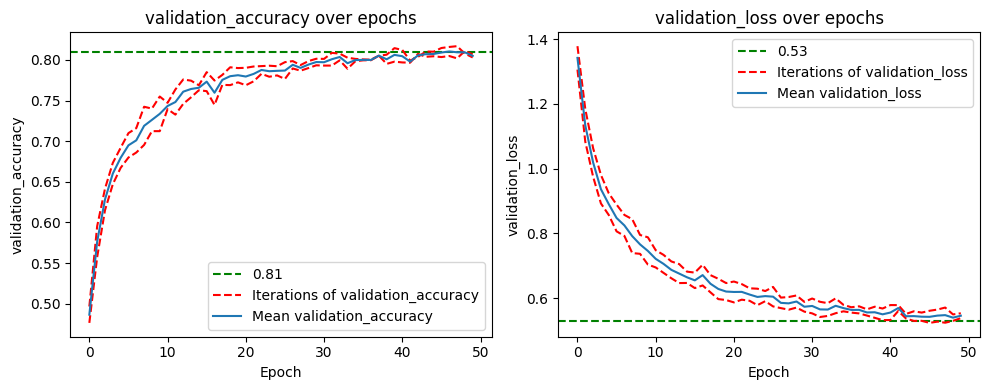

______________________________________________________________________________________________________________________________________________________


In [110]:
full_model_plot(x,hline=[0.81, 0.53])

<H3> Dense Neural Network - Amended </H3>

<b>Changes: </b>

-> Higher LR

-> Lower Dropout

<b>Reason for changes: </b>-> Underfitting

In [111]:
x,y = test_build(
    iters=2, 
    build_function=lambda x: build_nn(x, dropout=0.1), 
    input_shape=X[0].shape, 
    train_data=train_dataset, 
    val_data=test_dataset, 
    opt="adam_hlr",
    num_epochs=50
)

{'build_function': <function <lambda> at 0x0000022238159B40>, 'input_shape': (64, 32, 1), 'train_data': <PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>, 'val_data': <PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>, 'opt': 'adam_hlr', 'num_epochs': 50}
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 dense_24 (Dense)            (None, 256)               524544    
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                         

______________________________________________________________________________________________________________________________________________________
{'opt': 'adam_hlr'}


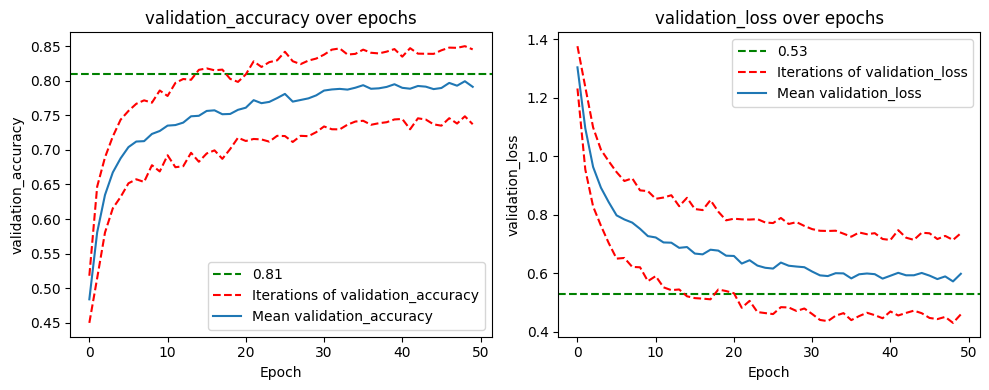

______________________________________________________________________________________________________________________________________________________


In [112]:
full_model_plot(x,hline=[0.81, 0.53])

The changes created an unstable training. This highlights one of the importances of normalization in the form of dropout.

<H3> Convolutional Neural Network </H3>

In [113]:
x,y = test_build(iters=2, build_function=build_cnn, input_shape=X[0].shape, train_data=train_dataset, val_data=test_dataset, num_epochs=50)

{'build_function': <function build_cnn at 0x000002223815B1C0>, 'input_shape': (64, 32, 1), 'train_data': <PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>, 'val_data': <PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>, 'num_epochs': 50}
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 32, 32)        320       
                                                                 
 re_lu (ReLU)                (None, 64, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 16, 32)       0         
 )                                                               
        

______________________________________________________________________________________________________________________________________________________
{'opt': 'adam'}


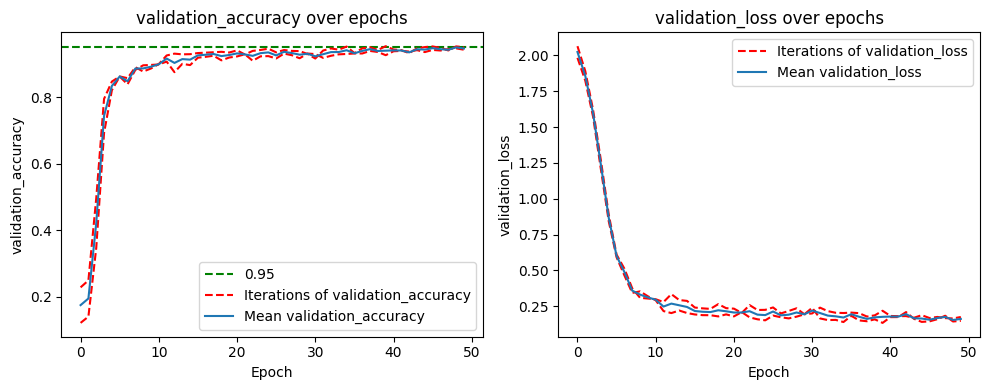

______________________________________________________________________________________________________________________________________________________


In [116]:
full_model_plot(x, hline=[0.95, None])

<H3> Convolutional Neural Network - Amended </H3>

<b>Changes: </b>

-> LR Exponential Decay

<b>Reason for changes: </b>-> Learning Stagnation

In [129]:
x,y = test_build(
    iters=2, 
    build_function=lambda x: build_cnn(x), 
    input_shape=X[0].shape, 
    train_data=train_dataset, 
    val_data=test_dataset, 
    opt="adam_exp",
    num_epochs=50
)

{'build_function': <function <lambda> at 0x000002223805FBE0>, 'input_shape': (64, 32, 1), 'train_data': <PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>, 'val_data': <PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>, 'opt': 'adam_exp', 'num_epochs': 50}
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 64, 32, 32)        320       
                                                                 
 re_lu_42 (ReLU)             (None, 64, 32, 32)        0         
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 32, 16, 32)       0         
 g2D)                                                   

______________________________________________________________________________________________________________________________________________________
{'opt': 'adam_exp'}


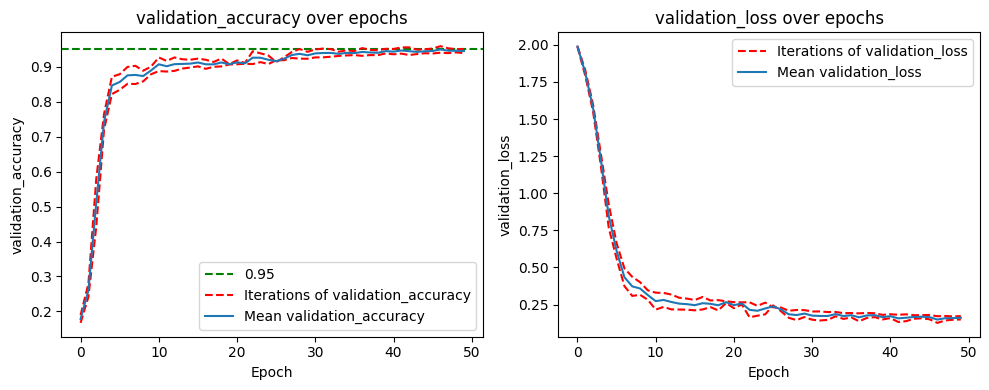

______________________________________________________________________________________________________________________________________________________


In [130]:
full_model_plot(x, hline=[0.95, None])

<H3> Recurrent Neural Network </H3>

In [12]:
x,y = test_build(iters=1, build_function=build_rnn, input_shape=X[0].shape, train_data=train_dataset, val_data=test_dataset, num_epochs=50)

{'build_function': <function build_rnn at 0x7b37a20836a0>, 'input_shape': (80, 64, 1), 'train_data': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 80, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>, 'val_data': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 80, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>, 'num_epochs': 50}


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 80, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,248 (102.53 KB)

 Trainable params: 25,992 (101.53 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50
97/97 - 7s - 72ms/step - accuracy: 0.2259 - loss: 2.1075 - val_accuracy: 0.2741 - val_loss: 1.8774
Epoch 2/50
97/97 - 6s - 59ms/step - accuracy: 0.2543 - loss: 1.9709 - val_accuracy: 0.3077 - val_loss: 1.8002
Epoch 3/50
97/97 - 6s - 58ms/step - accuracy: 0.2855 - loss: 1.8621 - val_accuracy: 0.3088 - val_loss: 1.7988
Epoch 4/50
97/97 - 6s - 58ms/step - accuracy: 0.3010 - loss: 1.7989 - val_accuracy: 0.3406 - val_loss: 1.6967
Epoch 5/50
97/97 - 6s - 58ms/step - accuracy: 0.3321 - loss: 1.7185 - val_accuracy: 0.3414 - val_loss: 1.6638
Epoch 6/50
97/97 - 6s - 63ms/step - accuracy: 0.3460 - loss: 1.6772 - val_accuracy: 0.3674 - val_loss: 1.6071
Epoch 7/50
97/97 - 6s - 58ms/step - accuracy: 0.3441 - loss: 1.6700 - val_accuracy: 0.2847 - val_loss: 1.8165
Epoch 8/50
97/97 - 6s - 59ms/step - accuracy: 0.3274 - loss: 1.7301 - val_accuracy: 0.3446 - val_loss: 1.6696
Epoch 9/50
97/97 - 6s - 59ms/step - accuracy: 0.3728 - loss: 1.6145 - val_accuracy: 0.3966 - val_loss: 1.5501
Epoch 10/5

2025-12-09 00:21:43.049613: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


______________________________________________________________________________________________________________________________________________________
{'opt': 'adam'}


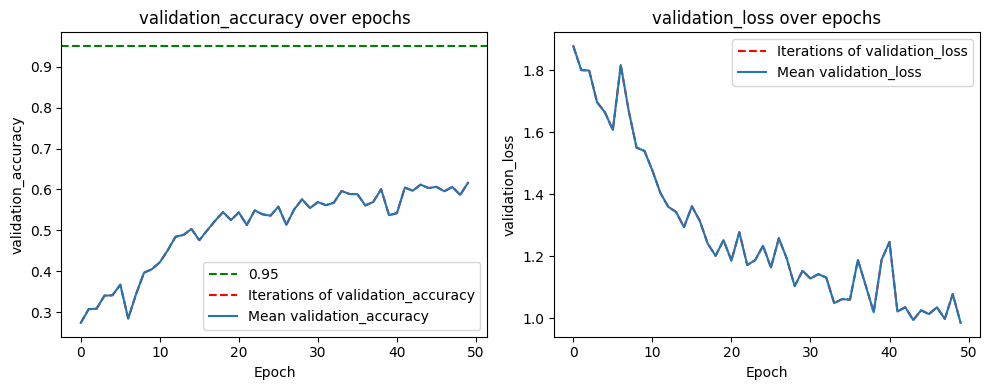

______________________________________________________________________________________________________________________________________________________


In [13]:
full_model_plot(x, hline=[0.95, None])

<H3> Recurrent Neural Network - Amended </H3>

<b>Changes: </b>

-> Architectural: SimpleRNN -> LSTM, Bidirectional 

<b>Reason for changes: </b>-> Model not expressive enough

In [18]:
x,y = test_build(iters=1, 
                 build_function=lambda x: build_rnn(x, cell_type=["lstm"], bidirectional=[True] ),  
                 input_shape=X[0].shape, train_data=train_dataset, val_data=test_dataset, num_epochs=50)

{'build_function': <function <lambda> at 0x7b37a1bfe520>, 'input_shape': (80, 64, 1), 'train_data': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 80, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>, 'val_data': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 80, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>, 'num_epochs': 50}


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_4 (Reshape)             │ (None, 80, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,712 (784.03 KB)

 Trainable params: 200,200 (782.03 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/50
97/97 - 30s - 311ms/step - accuracy: 0.4167 - loss: 1.6222 - val_accuracy: 0.4866 - val_loss: 1.5403
Epoch 2/50
97/97 - 30s - 311ms/step - accuracy: 0.5974 - loss: 1.0989 - val_accuracy: 0.6575 - val_loss: 1.0989
Epoch 3/50
97/97 - 30s - 313ms/step - accuracy: 0.6834 - loss: 0.8755 - val_accuracy: 0.6760 - val_loss: 0.9069
Epoch 4/50
97/97 - 35s - 358ms/step - accuracy: 0.7217 - loss: 0.7684 - val_accuracy: 0.7187 - val_loss: 0.8036
Epoch 5/50
97/97 - 32s - 329ms/step - accuracy: 0.7567 - loss: 0.6686 - val_accuracy: 0.7726 - val_loss: 0.6473
Epoch 6/50
97/97 - 32s - 333ms/step - accuracy: 0.7846 - loss: 0.5988 - val_accuracy: 0.7734 - val_loss: 0.6701
Epoch 7/50
97/97 - 36s - 369ms/step - accuracy: 0.8014 - loss: 0.5548 - val_accuracy: 0.8018 - val_loss: 0.5711
Epoch 8/50
97/97 - 35s - 364ms/step - accuracy: 0.8168 - loss: 0.5122 - val_accuracy: 0.8022 - val_loss: 0.5669
Epoch 9/50
97/97 - 35s - 365ms/step - accuracy: 0.8262 - loss: 0.4812 - val_accuracy: 0.8173 - val_loss:

______________________________________________________________________________________________________________________________________________________
{'opt': 'adam'}


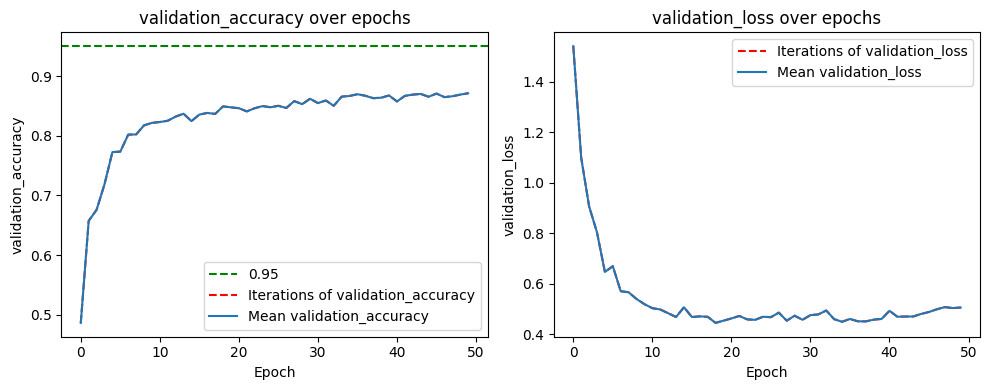

______________________________________________________________________________________________________________________________________________________


In [19]:
full_model_plot(x, hline=[0.95, None])

<H3> Convolutional + Recurrent Neural Network </H3>

In [21]:
x,y = test_build(iters=1, 
                 build_function=lambda x: build_crnn(x, rnn_cells=["lstm"], bidirectional=[True] ),  
                 input_shape=X[0].shape, train_data=train_dataset, val_data=test_dataset, num_epochs=50, opt="adam_exp"
                 )

{'build_function': <function <lambda> at 0x7b379996d620>, 'input_shape': (80, 64, 1), 'train_data': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 80, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>, 'val_data': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 80, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>, 'num_epochs': 50, 'opt': 'adam_exp'}


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 80, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 80, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 80, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       557,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 594,440 (2.27 MB)

 Trainable params: 594,184 (2.27 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50
97/97 - 125s - 1s/step - accuracy: 0.4591 - loss: 1.4306 - val_accuracy: 0.4566 - val_loss: 1.7827
Epoch 2/50
97/97 - 123s - 1s/step - accuracy: 0.6800 - loss: 0.8814 - val_accuracy: 0.7314 - val_loss: 1.2267
Epoch 3/50
97/97 - 124s - 1s/step - accuracy: 0.7691 - loss: 0.6459 - val_accuracy: 0.7999 - val_loss: 0.7660
Epoch 4/50
97/97 - 123s - 1s/step - accuracy: 0.8191 - loss: 0.5123 - val_accuracy: 0.8070 - val_loss: 0.5465
Epoch 5/50
97/97 - 123s - 1s/step - accuracy: 0.8464 - loss: 0.4260 - val_accuracy: 0.8590 - val_loss: 0.4116
Epoch 6/50
97/97 - 123s - 1s/step - accuracy: 0.8689 - loss: 0.3694 - val_accuracy: 0.8632 - val_loss: 0.3863
Epoch 7/50
97/97 - 123s - 1s/step - accuracy: 0.8850 - loss: 0.3193 - val_accuracy: 0.8640 - val_loss: 0.3837
Epoch 8/50
97/97 - 123s - 1s/step - accuracy: 0.9013 - loss: 0.2803 - val_accuracy: 0.8870 - val_loss: 0.3243
Epoch 9/50
97/97 - 123s - 1s/step - accuracy: 0.9139 - loss: 0.2471 - val_accuracy: 0.8957 - val_loss: 0.2953
Epoch 10/5

2025-12-09 02:34:47.074373: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


______________________________________________________________________________________________________________________________________________________
{'opt': 'adam_exp'}


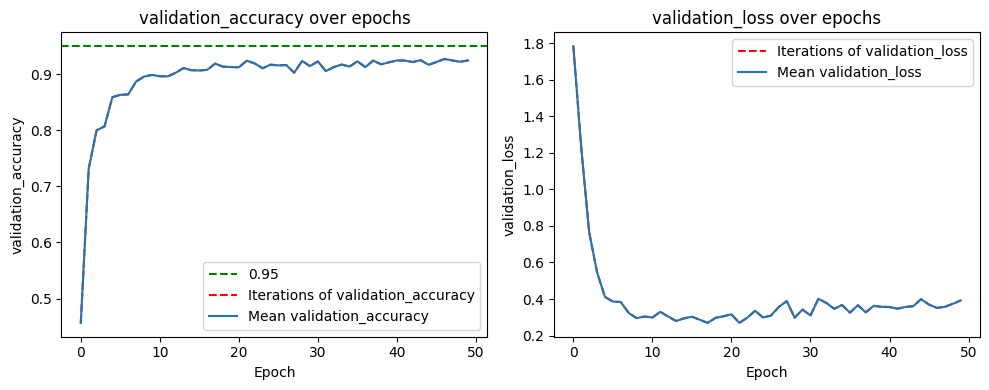

______________________________________________________________________________________________________________________________________________________


In [22]:
full_model_plot(x, hline=[0.95, None])

<H3> FINAL CHOSEN MODEL </H3>

In [13]:
plot_data, df_data, f1, m_ret = build_and_run( 
    build_function=lambda x: build_cnn(x), 
    input_shape=X[0].shape, 
    train_data=train_dataset, 
    val_data=test_dataset, 
    opt="adam_exp",
    num_epochs=50,
    scrap=False
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 64, 32)        320       
                                                                 
 re_lu (ReLU)                (None, 80, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 32, 64)        18496     
                                                                 
 re_lu_1 (ReLU)              (None, 40, 32, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 16, 64)       0         
 2D)                                                    

Text(0, 0.5, 'Loss')

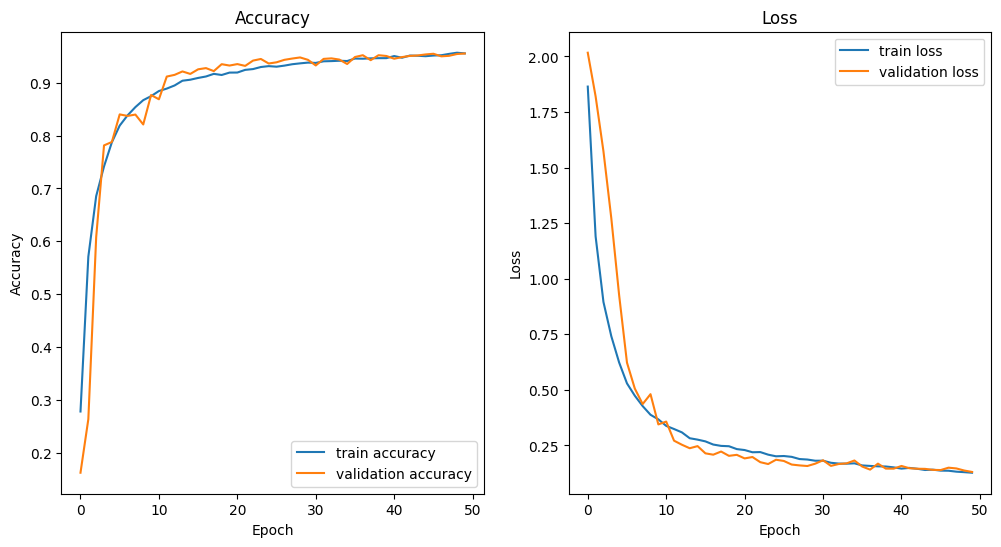

In [ ]:
# Plotting the final model
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].plot(range(50), plot_data["train_accuracy"], label="train accuracy")
ax[0].plot(range(50), plot_data["validation_accuracy"], label="validation accuracy")
ax[0].set_title("Accuracy")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")

ax[1].plot(range(50), plot_data["train_loss"], label="train loss")
ax[1].plot(range(50), plot_data["validation_loss"], label="validation loss")
ax[1].set_title("Loss")
ax[1].legend()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")

In [ ]:
y_pred, y_true = predict_from_dataset(m_ret, test_dataset)
y_pred = np.argmax(y_pred, axis=1)


array([3, 4, 4, ..., 7, 2, 2], dtype=int64)

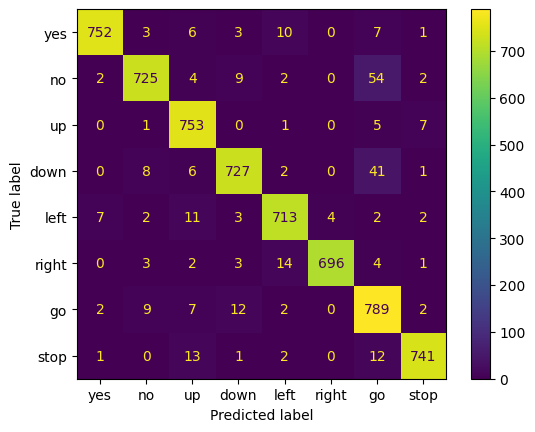

In [30]:
inv_dict = {v:k for k,v in index_dict.items()}
labels = [inv_dict[i] for i in range(len(inv_dict))]

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=labels).plot()

<H2> Augmentation </H2>

Now we take a look at combining the noise into the data in order to create noisy data.

In [9]:
# Adds to Spectrograms together (Since they are log tranformed)
def add_logmel_spectrograms(clean_log, noise_log, noise_scale=0.3):
    clean_lin = librosa.db_to_power(clean_log)
    noise_lin = librosa.db_to_power(noise_log)

    mixed_lin = clean_lin + noise_scale * noise_lin

    mixed_log = librosa.power_to_db(mixed_lin, ref=np.max)
    return mixed_log

def get_noise_snippet(noise_clip, length=SAMPLE_RATE):
    max_offset = len(noise_clip) - length
    offset = random.randint(0, max_offset)
    noise_spec = load_audio_spectrogram(noise_clip[offset:offset + length], from_file=False)
    return noise_spec

noise_clip_files = [f"data/_background_noise_/{x}" for x in os.listdir("data/_background_noise_")]
noise_clips = [librosa.load(i, sr=SAMPLE_RATE)[0] for i in noise_clip_files]

x_sample = load_audio_spectrogram(files[0])
x_noise_test = get_noise_snippet(noise_clips[0])


# Regular Audio
ipd.Audio(mel_to_audio(x_sample), rate=SAMPLE_RATE)


In [10]:
# Noise Clip
ipd.Audio(mel_to_audio(x_noise_test), rate=SAMPLE_RATE)

In [11]:
# Combined
example = add_logmel_spectrograms(x_sample, x_noise_test)
ipd.Audio(mel_to_audio(example), rate=SAMPLE_RATE)

We apply this to our dataset, then cache the noisy data and the clean validation set.

In [ ]:
def create_random_noisy_array(files, noise_clips, noise_choice=10, clip_choice=10):
    normal_audio = ((X * 80.0) - 80).squeeze(-1) #[load_audio_spectrogram(x) for x in files]
    noise = [get_noise_snippet(noise_clips[i//noise_choice]) for i in range(noise_choice*len(noise_clips))]

    X_arr = []
    y_arr = []

    count = 0
    for j in noise:
        clips = [random.choice(normal_audio) for x in range(clip_choice)]
        for i in clips:
            X_arr.append(add_logmel_spectrograms(i, j))
            y_arr.append(i)
            
            count+=1
    X_arr = (np.array(X_arr) + 80.0) / 80.0
    y_arr = (np.array(y_arr) + 80.0) / 80.0

    return X_arr, y_arr

X_noisy, y_noisy = create_random_noisy_array(files=files, noise_clips=noise_clips, noise_choice=6, clip_choice=1000)

np.save("X_noisy.npy", X_noisy)
np.save("y_noisy.npy", y_noisy)

In [12]:
X_noisy = np.load("X_noisy.npy")
y_noisy = np.load("y_noisy.npy")

X_noisy = np.array(X_noisy)[..., np.newaxis]
y_noisy = np.array(y_noisy)[..., np.newaxis]

print("X shape:", X_noisy.shape)
print("y shape:", y_noisy.shape)

X shape: (36000, 80, 64, 1)
y shape: (36000, 80, 64, 1)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_noisy, y_noisy, test_size=0.2, random_state=42
)

X_noisy = (X_noisy * 80.0) - 80.0
y_noisy = (y_noisy * 80.0) - 80.0

train_dataset = make_dataset(X_train, y_train)
test_dataset = make_dataset(X_test, y_test)

del X_noisy
del y_noisy


<H2> Denoising </H2>

With our newly augmented data, we can create our denoiser.

<H3> Creating the Decoder </H3>

In order to create the decoder, we use UNet. The UNet Archetecture Allows us to have multiple "encoding" spaces, using skip connections. This allows us to preserve the gradient and finer details, while the general shape goes through the full encoding process.

In [14]:
class DownConvBlock(tf.keras.layers.Layer):
    def __init__(self, ip_sz, op_sz, kernel_size=4, norm=True, dropout=0.0):
        super().__init__()

        self.conv = layers.Conv2D(
            op_sz, kernel_size,
            strides=2,
            padding="same",
            use_bias=not norm
        )
        
        self.norm = layers.LayerNormalization(axis=[1,2,3]) if norm else None
        self.act = layers.LeakyReLU(alpha=0.2)
        self.dropout = layers.Dropout(dropout) if dropout > 0.0 else None

    def call(self, x, training=False):
        x = self.conv(x)
        if self.norm: x = self.norm(x, training=training)
        x = self.act(x)
        if self.dropout: x = self.dropout(x, training=training)
        return x


class UpConvBlock(tf.keras.layers.Layer):
    def __init__(self, ip_sz, op_sz, kernel_size=4, stride=2, padding="same", dropout=0.0):
        super().__init__()

        self.deconv = layers.Conv2DTranspose(
            op_sz, kernel_size,
            strides=stride,
            padding=padding
        )
        
        self.norm = layers.LayerNormalization(axis=[1,2,3])
        self.act = layers.ReLU()
        
        self.dropout = layers.Dropout(dropout) if dropout > 0.0 else None
        

    def call(self, x, enc_ip, training=False):
        
        x = self.deconv(x)
        x = self.norm(x, training=training)
        x = self.act(x)
        if self.dropout: x = self.dropout(x, training=training)

        x = layers.Concatenate(axis=-1)([x, enc_ip])

        return x

def build_unet_autoencoder(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    d1 = DownConvBlock(1, 32)(inputs)
    d2 = DownConvBlock(32, 64)(d1)
    d3 = DownConvBlock(64, 128)(d2)

    bn = layers.Conv2D(256, 3, padding="same", activation="relu")(d3)

    # Decoder
    u1 = UpConvBlock(256, 128)(bn, d2)
    u2 = UpConvBlock(128+64, 64)(u1, d1)
    u3 = layers.Conv2DTranspose(32, 4, strides=2, padding="same", activation="relu")(u2)

    outputs = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(u3)

    return Model(inputs, outputs, name="unet_denoiser")

autoencoder = build_unet_autoencoder(X_train[0].shape)
autoencoder.summary()

Model: "unet_denoiser"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 64, 1)]  0           []                               
                                                                                                  
 down_conv_block (DownConvBlock  (None, 40, 32, 32)  82432       ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 down_conv_block_1 (DownConvBlo  (None, 20, 16, 64)  73728       ['down_conv_block[0][0]']        
 ck)                                                                                              
                                                                                      

In [15]:

autoencoder.compile(optimizer='adam', loss='mse')

hist = autoencoder.fit(
    X_train, y_train, epochs=7, shuffle=True, validation_data=(X_test, y_test)
)

Epoch 1/7
900/900 [==============================] - 48s 51ms/step - loss: 0.0251 - val_loss: 0.0196
Epoch 2/7
900/900 [==============================] - 47s 52ms/step - loss: 0.0187 - val_loss: 0.0168
Epoch 3/7
900/900 [==============================] - 49s 54ms/step - loss: 0.0165 - val_loss: 0.0171
Epoch 4/7
900/900 [==============================] - 49s 55ms/step - loss: 0.0152 - val_loss: 0.0149
Epoch 5/7
900/900 [==============================] - 49s 55ms/step - loss: 0.0144 - val_loss: 0.0138
Epoch 6/7
900/900 [==============================] - 49s 55ms/step - loss: 0.0136 - val_loss: 0.0132
Epoch 7/7
900/900 [==============================] - 49s 55ms/step - loss: 0.0130 - val_loss: 0.0130


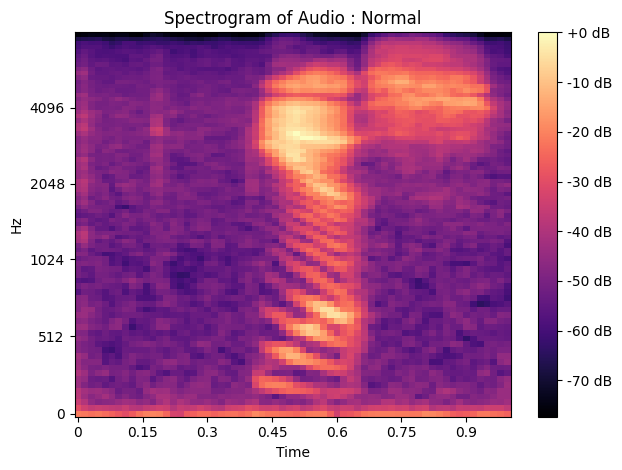

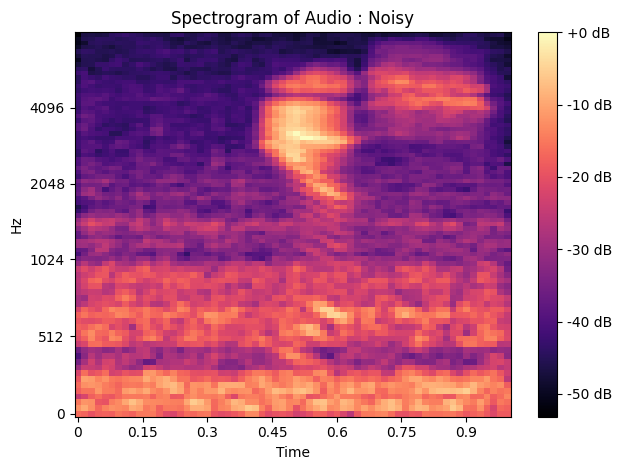

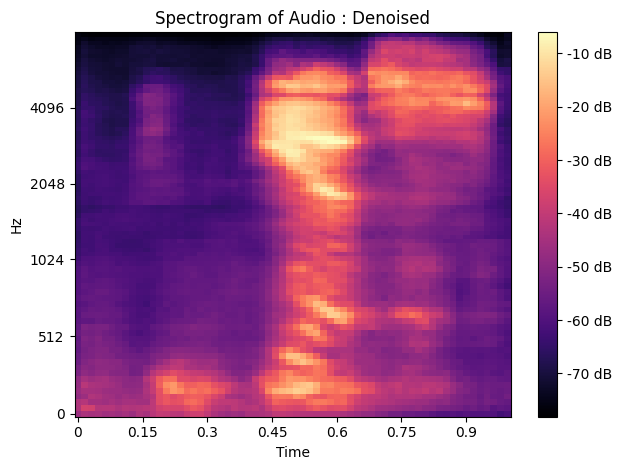

In [16]:
display_spec_quick_plot(x_sample, message=": Normal")
display_spec_quick_plot(example, message=": Noisy")


def complete_denoise(noisy_sample):
    example_norm = (noisy_sample + 80.0) / 80.0
    example_decoded = np.array(autoencoder(np.array([example_norm[..., np.newaxis]]))).squeeze(-1)[0]
    example_unnormed = (example_decoded * 80) - 80
    return example_unnormed

example_denoised = complete_denoise(example)

display_spec_quick_plot(example_denoised, ": Denoised")


In [ ]:
#Normal Audio
ipd.Audio(mel_to_audio(x_sample), rate=SAMPLE_RATE)

In [ ]:
#Noisy Audio
ipd.Audio(mel_to_audio(example), rate=SAMPLE_RATE)

In [ ]:
#Denoised Audio
ipd.Audio(mel_to_audio(example_denoised), rate=SAMPLE_RATE)

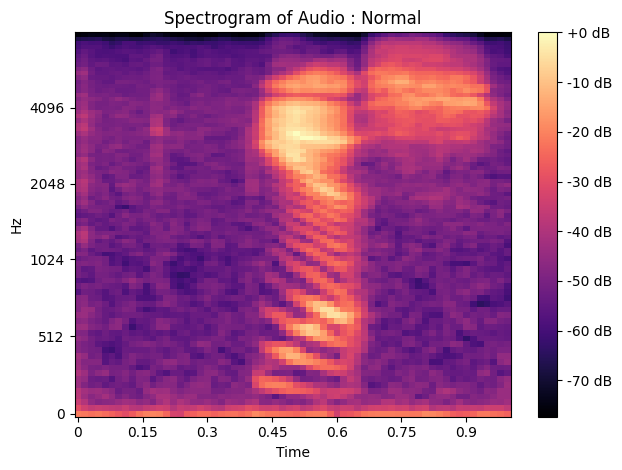

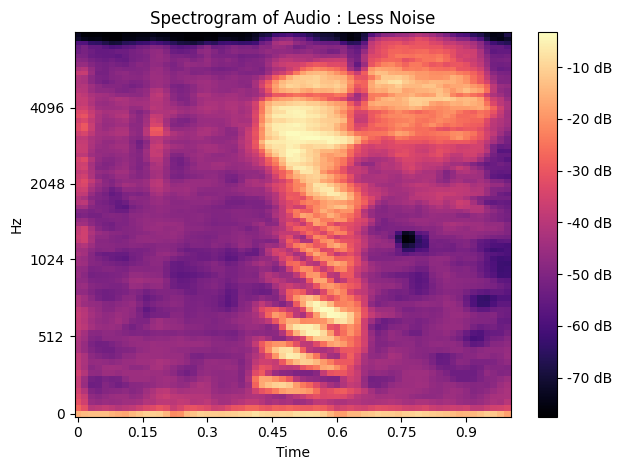

In [37]:
display_spec_quick_plot(x_sample, message=": Normal")
extreme_denoise = complete_denoise(x_sample)


display_spec_quick_plot(extreme_denoise, message=": Less Noise")

In [ ]:
#Denoised Audio
ipd.Audio(mel_to_audio(extreme_denoise), rate=SAMPLE_RATE)

<H2> Conclusion </H2>

In this project we created a classification on a command set, useful for speech to text classification. We found that the CNN worked best for the data that we were given. 

We also created a denoiser on augmented data, and found that the result could also be used on the non-augmented data as well. 

<H3> Next Steps & Limitations </H3>

One of the big ideas in audio processing is the ability to stream data, which is why RNN is so powerful. Since it can deal with sequential data, it can perform real time audio processing. This is challenging for this model that uses CNN, (and even bidirectional RNN), since both use the context of the frequencies that come later in the sequence. A real-time model would be a nice next step. 

Additionally, since we were categorizing into only 8 commands, this is very different than true text to speech. In order to accomplish that, we would have to combine this method with tokenization and text processing to truly turn audio into human speech.

D. Griffin and Jae Lim, "Signal estimation from modified short-time Fourier transform," in IEEE Transactions on Acoustics, Speech, and Signal Processing, vol. 32, no. 2, pp. 236-243, April 1984, doi: 10.1109/TASSP.1984.1164317. http://hil.t.u-tokyo.ac.jp/~kameoka/SAP/papers/Griffin1984__Signal_Estimation_from_Modified_Short-Time_Fourier_Transform.pdf

rupert ai. (2023, May 5). The U-Net (actually) explained in 10 minutes [Video]. YouTube. https://www.youtube.com/watch?v=NhdzGfB1q74

I. Sargis, Autoencoders Demystified: Audio Signal Denoising  Medium, May 2, 2022, medium.com/@sriskandaryan/autoencoders-demystified-audio-signal-denoising-32a491ab023a.

Valerio Velardo - The Sound of AI. (2020, September 7). Short-Time Fourier transform explained easily [Video]. YouTube. https://www.youtube.com/watch?v=-Yxj3yfvY-4



Data: https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
